In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import pickle
import torch.nn as nn
from torch.autograd import Variable
import random
import numpy as np

In [2]:
#TODO add split 1-35 train and 36-50 test

## Create dataset

In [3]:
# loading relevancy data

path = 'C:/Users/User/OneDrive - NTNU/NTNU/Prosjekt oppgave NLP/dataset/CORD-19/'
file = 'relevance_data.csv'

label_data = pd.read_csv(path + file)
label_data.head()

,Unnamed: 0,topic_id,round_id,cord_uid,relevancy
0,0,1,4.5,005b2j4b,2
1,1,1,4.0,00fmeepz,1
2,2,1,0.5,010vptx3,2
3,3,1,2.5,0194oljo,1
4,4,1,4.0,021q9884,1


In [4]:
# loading topics data

path = 'C:/Users/User/OneDrive - NTNU/NTNU/Prosjekt oppgave NLP/dataset/CORD-19/'
file = 'topics.csv'

topics = pd.read_csv(path + file)
topics.head()

,query_id,query,question,narrative
0,1,coronavirus origin,what is the origin of COVID-19,seeking range of information about the SARS-Co...
1,2,coronavirus response to weather changes,how does the coronavirus respond to changes in...,seeking range of information about the SARS-Co...
2,3,coronavirus immunity,will SARS-CoV2 infected people develop immunit...,seeking studies of immunity developed due to i...
3,4,how do people die from the coronavirus,what causes death from Covid-19?,Studies looking at mechanisms of death from Co...
4,5,animal models of COVID-19,what drugs have been active against SARS-CoV o...,Papers that describe the results of testing d...


In [5]:
len(label_data)

69318

In [6]:
train_topics = [i+1 for i in range(35)]
test_topics = [i+1 for i in range(35,50)]

In [7]:
# available models: ['bert-base-uncased', "allenai/scibert_scivocab_uncased", "gsarti/covidbert-nli"]

def normalize_tensor(tensor):
    tensor_normed = []
    norm = torch.norm(tensor)
    if norm>0:
        tensor_normed = tensor/norm
    else:
        tensor_normed = tensor
    return tensor_normed

def get_tesors(row, topic_field, doc_field, model):
    topic_path = "C:/Users/User/Documents/NTNU/NLP/CORD-19/topic_embeddings/"
    doc_path = "C:/Users/User/Documents/NTNU/NLP/CORD-19/Embeddings/786/"
    doc_id = row["cord_uid"]
    topic_id = row["topic_id"]
    topic_tensor = []
    doc_tensor = []
    
    doc_embedding_file = doc_path + doc_id + ".txt"
    try:
        with open(doc_embedding_file, "rb") as fp:   # Unpickling
            doc_embedding = pickle.load(fp)
    except:
        return [[0]], [[0]]
        
    doc_tensor = doc_embedding["models"][model][doc_field]
            
    topic_embedding_file = topic_path + str(topic_id) + ".txt"
    with open(topic_embedding_file, "rb") as fp:   # Unpickling
        topic_embedding = pickle.load(fp)
        
    topic_tensor =  topic_embedding["models"][model][topic_field]
    
    topic_tensor = normalize_tensor(topic_tensor)
    doc_tensor = normalize_tensor(doc_tensor)
    
    return topic_tensor, doc_tensor
    

In [8]:
def join_tensors(tensor_a,tensor_b):
    n = len(tensor_a)
    m = len(tensor_b)
    c = torch.empty(n + m)
    c[0:n] = tensor_a
    c[n:(n+m)] = tensor_b
    return c

In [9]:
def isNaN(num):
    return num != num

In [10]:
def load_data(n_datapoints, doc_field, query_field, encoder_model):
    
    topic_dataset = torch.empty(n_datapoints, 768)
    document_dataset = torch.empty(n_datapoints, 768)
    rel = torch.empty(n_datapoints)
    
    miss = 0
    i = 0
    for idx, row in label_data.iterrows():
        if idx < num:
            a, b = get_tesors(row, query_field, doc_field, encoder_model)
            if len(a[0]) != 1:
              
                topic_dataset[i] = a[0]
                document_dataset[i] = b[0]
        
                rel[i] = row["relevancy"]
                i += 1
            else:
                miss += 1
            if(idx % 5000) == 0:
                print(idx)
    
    document_dataset = document_dataset[0:(num-miss)]
    topic_dataset = topic_dataset[0:(num-miss)]
    rel = rel[0:(num-miss)]
    
    return topic_dataset, document_dataset, rel, miss

In [11]:
def load_data_top_id(type_d, doc_field, query_field, encoder_model):
    
    label_dat_top = []
    if type_d == "train":
        label_dat_top = label_data[label_data["topic_id"] < 36]
    else:
        label_dat_top = label_data[label_data["topic_id"] > 35]
        
    n_datapoints = len(label_dat_top["topic_id"])
    print("Number of datapoints for ",type_d," ",n_datapoints)
    topic_dataset = torch.empty(n_datapoints, 768)
    document_dataset = torch.empty(n_datapoints, 768)
    rel = torch.empty(n_datapoints)
    
    miss = 0
    i = 0
    for idx, row in label_dat_top.iterrows():
        a, b = get_tesors(row, query_field, doc_field, encoder_model)
        if len(a[0]) != 1:

            topic_dataset[i] = a[0]
            document_dataset[i] = b[0]

            rel[i] = row["relevancy"]
            i += 1
        else:
            miss += 1
        if(idx % 5000) == 0:
            print(idx)
    
    document_dataset = document_dataset[0:(num-miss)]
    topic_dataset = topic_dataset[0:(num-miss)]
    rel = rel[0:(num-miss)]
    
    return topic_dataset, document_dataset, rel, miss

In [12]:
def join_datasets(doc, query, relevancy, num_class, type_join):
    relevancy_temp = relevancy
    if num_class == 2:
        for i, rel in enumerate(relevancy_temp):
            if rel > 0.01:
                relevancy_temp[i] = 1
    n = len(relevancy_temp)
    X_dataset = []
    
    if type_join == "multi":
        X_dataset = torch.empty(n, 768)
        for i in range(n):
            X_dataset[i] = doc[i]*query[i]
    else: 
        X_dataset = torch.empty(n, 768*2)
        for i in range(n):
            X_dataset[i] = join_tensors(doc[i],query[i])
    joint_dataset = torch.cat((X_dataset, relevancy_temp.unsqueeze(1)), 1)
    return joint_dataset

In [13]:
#loading 
num = 40000 # max: 69318

available_models = ['bert-base-uncased', "allenai/scibert_scivocab_uncased", "gsarti/covidbert-nli"]
bert_model = available_models[2]
query_field = "query"
doc_field = "title"



In [14]:
label_dat_top = label_data[label_data["topic_id"] < 35]
label_dat_top.head()   

,Unnamed: 0,topic_id,round_id,cord_uid,relevancy
0,0,1,4.5,005b2j4b,2
1,1,1,4.0,00fmeepz,1
2,2,1,0.5,010vptx3,2
3,3,1,2.5,0194oljo,1
4,4,1,4.0,021q9884,1


In [15]:
topic_dat_train, doc_dat_train, rel_dat_train, miss_train  = load_data_top_id("train", doc_field, query_field, bert_model)
topic_dat_test, doc_dat_test, rel_dat_test, miss_test  = load_data_top_id("test", doc_field, query_field, bert_model)

Number of datapoints for  train   52865
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
Number of datapoints for  test   16453
55000
60000
65000


In [16]:
joining_type = "multi"

# Model Hyper Parameters 
input_size = 768*2
if joining_type == "multi":
    input_size = 768

model_type = "deep_1"
num_classes = 2
num_epochs = 20
batch_size = 1000
learning_rate = 0.003

# Proportion of training to test dat
training_split = 0.8

In [17]:
print(list(topic_dat_train.size()))
print(list(doc_dat_train.size()))
print(list(rel_dat_train.size()))
print(list(topic_dat_test.size()))
print(list(doc_dat_test.size()))
print(list(rel_dat_test.size()))

[37937, 768]
[37937, 768]
[37937]
[16453, 768]
[16453, 768]
[16453]


In [18]:
train_data = join_datasets(topic_dat_train, doc_dat_train, rel_dat_train, num_classes, joining_type)
test_data = join_datasets(topic_dat_test, doc_dat_test, rel_dat_test, num_classes, joining_type)

In [19]:
print(list(train_data.size()))
print(list(test_data.size()))

[37937, 769]
[16453, 769]


In [20]:
"""
num_dat_points = len(rel_dat)
ind = [i for i in range(num_dat_points)]

random.shuffle(ind)

split_ind = round(0.8*num_dat_points)

train_ind = ind[0:split_ind]
test_ind = ind[(split_ind+1):num_dat_points]

print(list(dat[train_ind].size()))
print(list(dat[test_ind].size()))


print(rel_dat[train_ind].int().tolist().count(0)/len(train_ind))
print(rel_dat[train_ind].int().tolist().count(1)/len(train_ind))
if num_classes == 3:
    print(rel_dat[train_ind].int().tolist().count(2)/len(train_ind))
"""

print(rel_dat_train.int().tolist().count(0)/len(rel_dat_train))
print(rel_dat_train.int().tolist().count(1)/len(rel_dat_train))
if num_classes == 3:
    print(rel_dat_train.int().tolist().count(2)/len(rel_dat_train))

print(rel_dat_test.int().tolist().count(0)/len(rel_dat_test))
print(rel_dat_test.int().tolist().count(1)/len(rel_dat_test))
if num_classes == 3:
    print(rel_dat_test.int().tolist().count(2)/len(rel_dat_test))
    


# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

0.6459656799430635
0.3540343200569365
0.5478636114994226
0.45201483012216614


In [21]:
model = 0
if model_type == "simple":
    model = nn.Sequential(
                     nn.Linear(input_size, num_classes),
                     nn.Sigmoid())
elif model_type == "deep":
     model = nn.Sequential(nn.Linear(input_size, 128),
                         nn.ReLU(),
                         nn.Linear(128, 64),
                         nn.ReLU(),
                         nn.Linear(64, num_classes),
                         nn.Sigmoid())
elif model_type == "deep_1":
     model = nn.Sequential(nn.Linear(input_size, 768),
                         nn.ReLU(),
                         nn.Linear(768, num_classes),
                         nn.Sigmoid())
elif model_type == "no_relu":
    model = nn.Sequential(nn.Linear(input_size, 768),
                         nn.Linear(768, 1))
else:
    model = nn.Sequential(nn.Linear(input_size, 768),
                         nn.ReLU(),
                         nn.Linear(768, 1))

In [22]:
def valid():
    

    # Test the Model
    correct = 0
    total = 0
    for X_y in test_loader:
        y = X_y[:,input_size]
        y = y.int()
        y =  torch.LongTensor(y.tolist())
        #print(y)
        X = X_y[:,0:(input_size)].tolist()
        X = torch.tensor(X)
        outputs = model(X)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum()

    print('Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))
    return correct / total

In [23]:
def valid_loss():
    # Test the Model
    correct = 0
    total = 0
    s = 0
    for X_y in test_loader:
        y = X_y[:,input_size]
        y = y.int()
        y = torch.LongTensor(y.tolist())
        if len(y) == batch_size:
            #print(y)
            X = X_y[:,0:(input_size)].tolist()
            X = torch.tensor(X)
            outputs = model(X)
            print(list(outputs.size()))
            print(list(y.size()))
            #print(outputs)
            loss = criterion(outputs, y)
            s += loss
    print(s)
    return s

In [24]:
"""  
# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out
model = LogisticRegression(input_size, num_classes)
"""

'  \n# Model\nclass LogisticRegression(nn.Module):\n    def __init__(self, input_size, num_classes):\n        super(LogisticRegression, self).__init__()\n        self.linear = nn.Linear(input_size, num_classes)\n    \n    def forward(self, x):\n        out = self.linear(x)\n        return out\nmodel = LogisticRegression(input_size, num_classes)\n'

In [25]:


# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  


loss_list = []
valid_list = []
# Training the Model
for epoch in range(num_epochs):
    for i, (X_y) in enumerate(train_loader):
        
        y = X_y[:,input_size]
        #print(y)
        X = X_y[:,0:(input_size)].tolist()
        #print(X)
        #print(list(X.size()))
        #print(len(y))
        #y = y.int()
        print(list(y.size()))
        #print(len(y))
        y =  torch.FloatTensor(y)

        print(list(y.size()))
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(torch.tensor(X))
        #print(outputs)
        #print(y)
        loss = criterion(outputs, y)
        #print(loss)
        #print(model)
        loss.backward()

        optimizer.step()
        loss_list.append(loss)
        if (i) % 400 == 0:
            #print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
            #       % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
            print(epoch)
            print(loss)
    if epoch % 10 == 0:
        print("Valid loss:")
        l = valid_loss()
        valid_list.append(l)



[1000]
[1000]


C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2) must match the size of tensor b (1000) at non-singleton dimension 1

In [ ]:
# Test the Model
correct = 0
total = 0
for X_y in test_loader:
    y = X_y[:,input_size]
    y = y.int()
    y =  torch.LongTensor(y.tolist())
    #print(y)
    X = X_y[:,0:(input_size)].tolist()
    X = torch.tensor(X)
    outputs = model(X)
    print(outputs)
    _, predicted = torch.max(outputs.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum()
    
print('Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

In [ ]:
plt.plot(loss_list)

In [ ]:
valid_list 

In [26]:
# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  


loss_list = []
valid_list = []

# Training the Model
for epoch in range(18):
    for i, (X_y) in enumerate(train_loader):
        
        y = X_y[:,input_size]
        #print(y)
        X = X_y[:,0:(input_size)].tolist()
        #print(X)
        #print(list(X.size()))
        #print(len(y))
        y = y.int()
        #print(list(y.size()))
        #print(len(y))
        y =  torch.LongTensor(y.tolist())
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(torch.tensor(X))
        loss = criterion(outputs, y)
        #print(loss)
        #print(model)
        loss.backward()

        optimizer.step()
        loss_list.append(loss)
        if (i) % 400 == 0:
            #print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
            #       % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
            print(epoch)
            print(loss)
    if epoch % 1 == 0:
        
        for i, (X_y) in enumerate(test_loader):
            #print(i)
            if i not in [2,15,16]:
                y = X_y[:,input_size]
                #print(y)
                X = X_y[:,0:(input_size)].tolist()
                #print(X)
                #print(list(X.size()))
                #print(len(y))
                y = y.int()
                #print(list(y.size()))
                #print(len(y))
                y =  torch.LongTensor(y.tolist())
                # Forward + Backward + Optimize
                optimizer.zero_grad()
                outputs = model(torch.tensor(X))
                loss = criterion(outputs, y)
                if epoch % 10 == 0 and i == 1:
                    print(loss)
                valid_list.append(loss)
            else:
                bbbbbb = 10
                #print(list(y.size()))



0
tensor(0.6924, grad_fn=<NllLossBackward>)
tensor(0.6858, grad_fn=<NllLossBackward>)
1
tensor(0.6629, grad_fn=<NllLossBackward>)
2
tensor(0.6519, grad_fn=<NllLossBackward>)
3
tensor(0.6547, grad_fn=<NllLossBackward>)
4
tensor(0.6371, grad_fn=<NllLossBackward>)
5
tensor(0.6289, grad_fn=<NllLossBackward>)
6
tensor(0.6293, grad_fn=<NllLossBackward>)
7
tensor(0.6275, grad_fn=<NllLossBackward>)
8
tensor(0.6114, grad_fn=<NllLossBackward>)
9
tensor(0.6062, grad_fn=<NllLossBackward>)
10
tensor(0.6120, grad_fn=<NllLossBackward>)
tensor(0.6653, grad_fn=<NllLossBackward>)
11
tensor(0.6230, grad_fn=<NllLossBackward>)
12
tensor(0.6235, grad_fn=<NllLossBackward>)
13
tensor(0.6089, grad_fn=<NllLossBackward>)
14
tensor(0.6167, grad_fn=<NllLossBackward>)
15
tensor(0.5971, grad_fn=<NllLossBackward>)
16
tensor(0.5879, grad_fn=<NllLossBackward>)
17
tensor(0.6187, grad_fn=<NllLossBackward>)


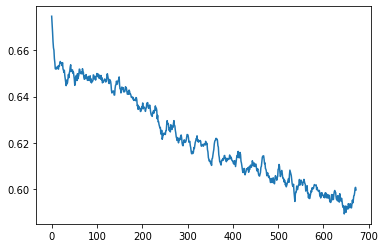

In [27]:
r = 10
l = np.convolve(loss_list, [1/r for i in range(r)], mode='full') 
plt.plot(l[r:(len(l)-r)])

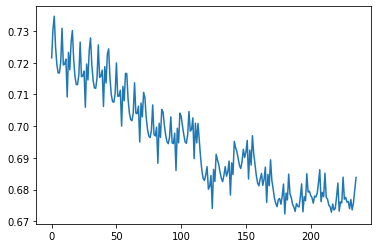

In [28]:
r = 15
l = np.convolve(valid_list, [1/r for i in range(r)], mode='full') 
plt.plot(l[r:(len(l)-r)])

In [ ]:
plt.plot(valid_list)

In [ ]:
rel_dat.int().tolist().count(0)/len(rel_dat)

In [29]:
mod = []
for param in model.parameters():
    mod.append(param)
    print(list(param.size()))

[768, 768]
[768]
[2, 768]
[2]


In [ ]:
l[0]
print(list(l[2].size()))

In [ ]:
l[1]

In [ ]:
input_vector = train_data[10][0:768]
print(len(input_vector))

In [ ]:
model(train_data[10][0:768])

In [42]:
n = 532
X = mod[0]
print(list(X.size()))
input_vector = train_data[n][0:768]
print(train_data[n][768])
print(model(train_data[n][0:768]))
print(list(input_vector.size()))
k = torch.mv(X,input_vector)
k = k + mod[1]
print(list(k.size()))
k = torch.tensor([max(0,x) for x in k])
print(list(k.size()))
k_alt =  torch.dot(mod[2][1], k)
k = torch.mv(mod[2],k)
k_alt = k_alt + mod[3][1]


k = k + mod[3]
print(k, k_alt)
print(list(k.size()))
k = torch.sigmoid(k)
print(k)

[768, 768]
tensor(0., grad_fn=<SelectBackward>)
tensor([0.7368, 0.2637], grad_fn=<SigmoidBackward>)
[768]
[768]
[768]
tensor([ 1.0294, -1.0270], grad_fn=<AddBackward0>) tensor(-1.0270, grad_fn=<AddBackward0>)
[2]
tensor([0.7368, 0.2637], grad_fn=<SigmoidBackward>)


In [ ]:
 a = l[0].tolist()

In [ ]:
a

In [ ]:
# Test the Model
correct = 0
total = 0
for X_y in train_loader:
    y = X_y[:,input_size]
    y = y.int()
    y =  torch.LongTensor(y.tolist())
    #print(y)
    X = X_y[:,0:(input_size)].tolist()
    X = torch.tensor(X)
    outputs = model(X)
    #print(outputs)
    _, predicted = torch.max(outputs.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum()
    
print('Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

In [34]:

path = "C:/Users/User/Documents/NTNU/NLP/CORD-19/results/"
name = "deep_model"
file = path + name + ".txt"
with open(file, "wb") as fp:   #Pickling
    pickle.dump(mod, fp)